In [4]:
from _utils import *
from model import *

In [5]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'


#image_shape = (224, 224)
data_folder = os.path.join(os.getcwd(), '../data/train')
label_df = masks_read(os.path.join(os.getcwd(), '../data'))

In [4]:
tf.reset_default_graph()

sess = tf.Session()
model_dir = "./save_model/"
saver = tf.train.import_meta_graph(os.path.join(model_dir, "airbus_model.meta"))
#saver.restore(sess, tf.train.latest_checkpoint(model_dir))
saver.restore(sess, os.path.join(model_dir,"airbus_model"))
graph = tf.get_default_graph()
x_holder = graph.get_tensor_by_name("x_holder:0")
y_holder = graph.get_tensor_by_name("y_holder:0")
bce_loss = graph.get_tensor_by_name("bce_loss:0")
dice_loss = graph.get_tensor_by_name("dice_loss:0")
pixel_pred = graph.get_tensor_by_name("pixel_pred:0")
accuracy = graph.get_tensor_by_name("accuracy:0")
iou = graph.get_tensor_by_name("iou:0")

INFO:tensorflow:Restoring parameters from ./save_model/airbus_model


In [11]:
train_ids, valid_ids = train_test_split(label_df.index.values, train_size=0.8,
                                        stratify=label_df['HasShip'].values, random_state=99)
# train_df = label_df.loc[train_ids]
valid_df = label_df.loc[valid_ids]
batch_size = 16
data_folder = os.path.join(os.getcwd(), '../data/train')

data_generator = batch_gen(data_folder, valid_df, batch_size, is_training=False, augment=False)
num_examples = (valid_df.shape[0] // batch_size) * batch_size
total_loss_bce = 0
total_loss_dice = 0
total_acc = 0
total_iou = [0,0,0,0,0]
next(data_generator)

/home/rui/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(array([[[[ 0.29585489,  0.292431  ,  0.        ],
          [ 0.28906666,  0.22541763,  0.        ],
          [ 0.307537  ,  0.23936287,  0.        ],
          ..., 
          [ 0.28201394,  0.25634179,  0.03023155],
          [ 0.2049526 ,  0.25772021,  0.03994705],
          [ 0.27985767,  0.23059831,  0.02419418]],
 
         [[ 0.25111596,  0.24450589,  0.        ],
          [ 0.18986789,  0.22511374,  0.03732994],
          [ 0.30068821,  0.26429746,  0.        ],
          ..., 
          [ 0.41100801,  0.27560826,  0.05960143],
          [ 0.25536675,  0.25969331,  0.07531472],
          [ 0.2594106 ,  0.21312348,  0.00803127]],
 
         [[ 0.23855779,  0.22881731,  0.09768978],
          [ 0.24458783,  0.20347103,  0.0475993 ],
          [ 0.26350147,  0.2931242 ,  0.        ],
          ..., 
          [ 0.21645998,  0.22609201,  0.01057009],
          [ 0.27892306,  0.14650142,  0.03576934],
          [ 0.23549615,  0.25041674,  0.136285  ]],
 
         ..., 
         [

In [21]:
X_batch, y_batch = next(data_generator)
loss_bce, loss_dice, accuracy_val, iou_val = sess.run([bce_loss, dice_loss, accuracy, iou], feed_dict={x_holder: X_batch, y_holder: y_batch})

In [22]:
print(loss_bce, loss_dice)

0.00584647 8.08572e-05


In [12]:
for _ in tqdm(range(0, num_examples, batch_size)):
    X_batch, y_batch = next(data_generator)
    loss_bce, loss_dice, accuracy_val, iou_val = sess.run([bce_loss, dice_loss, accuracy, iou],
                                        feed_dict={x_holder: X_batch, y_holder: y_batch})
    total_loss_bce += loss_bce
    total_loss_dice += loss_dice
    total_acc += accuracy_val
    total_iou = [total_iou[i] + iou_val[i] for i in range(len(iou_val))]
print(total_loss_bce / (num_examples / batch_size), total_loss_dice / (num_examples / batch_size), total_acc / (num_examples / batch_size), [x / (
num_examples / batch_size) for x in total_iou])


100%|██████████| 140/140 [09:00<00:00,  3.86s/it]

0.00791481987606 2.8808811034e-05 0.997392160978 [2224.430655343192, 420.87946428571428, 1117.2867558070591, 586061.40312499995, 0.52116243988275524]


In [13]:
tot = sum([2224.430655343192, 420.87946428571428, 1117.2867558070591, 586061])
fal = sum([420.87946428571428, 1117.2867558070591])
fal/tot

0.0026078411040879675

In [17]:
iou1 = np.array(total_iou) / (num_examples / batch_size)

In [18]:
TP, FP, FN, TN = iou1[:4]

In [20]:
5*TP/(5*TP + 4*FP + FN)

0.79883551791614804

In [7]:
import matplotlib.pyplot as plt

In [6]:
label_df.head()

,HasShip,EncodedPixelsList
ImageId,,
b6f2df649.jpg,2,[267574 4 268335 11 269096 18 269857 25 270618...
1b5de27c9.jpg,3,[462094 2 462860 4 463625 8 464391 10 465157 1...
eb48da2ea.jpg,6,[27735 3 28497 9 29259 16 30024 16 30792 12 31...
4ac696b08.jpg,5,[263680 1 264447 4 265214 6 265981 6 266749 6 ...
5046b7f38.jpg,1,[208757 1 209524 4 210292 5 211059 8 211826 10...


caff6ee1d.jpg


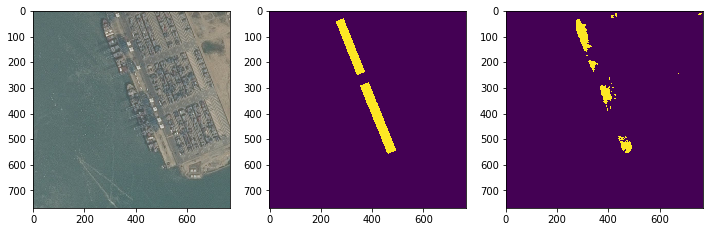

In [7]:
img_name = label_df.index[6]
print(img_name)
img_x = plt.imread(os.path.join(data_folder,img_name))
img_x = img_x[np.newaxis,:]
if label_df.loc[img_name, 'HasShip'] == 0:
    img_y = rle_decode_all([])
else:
    img_y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
img_z = sess.run(pixel_pred, feed_dict={x_holder:img_x/255.0})

_, axes = plt.subplots(1,3,figsize=(12,6))
axes[0].imshow(np.squeeze(img_x))
axes[1].imshow(img_y)
axes[2].imshow(np.squeeze(img_z))
plt.show()

b6f2df649.jpg
1b5de27c9.jpg
eb48da2ea.jpg
4ac696b08.jpg
5046b7f38.jpg
9ed2d4723.jpg
caff6ee1d.jpg
e374ed1ee.jpg
e30eda800.jpg
07bfafc44.jpg



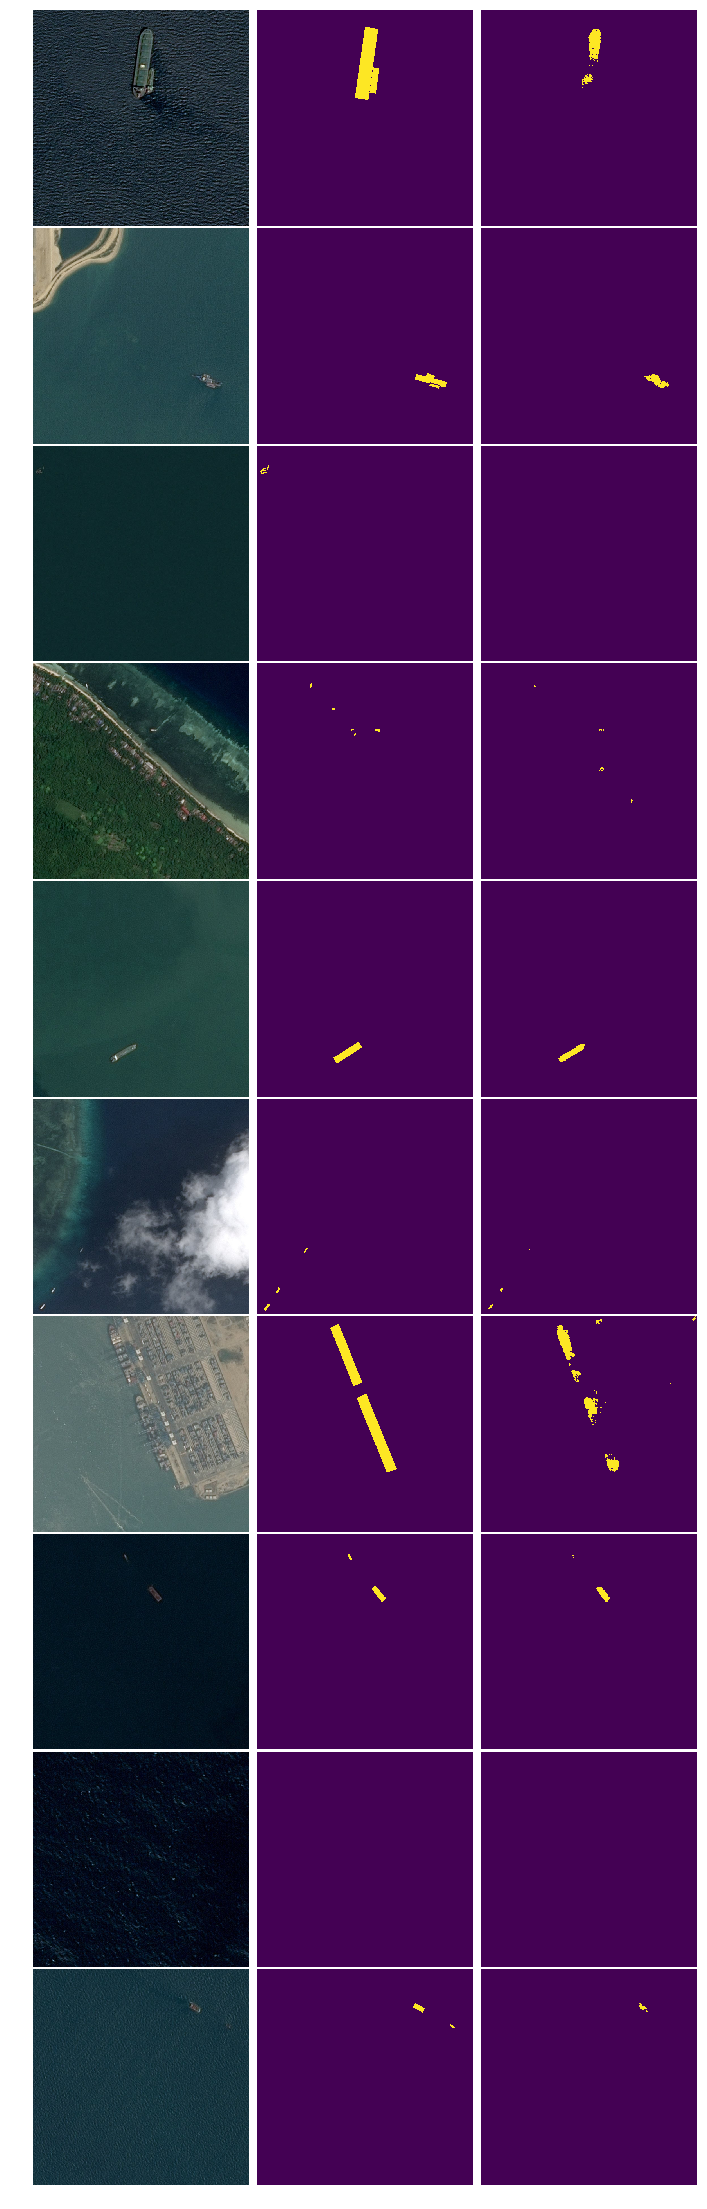

In [8]:
img_x = [0]*10
img_y = [0]*10
img_z = [0]*10
_, axes = plt.subplots(10,3,figsize=(12,40))
for i, img_name in tqdm_notebook(enumerate(label_df.index[:10])):
    print(img_name)
    img_x[i] = plt.imread(os.path.join(data_folder,img_name))
    img_x[i] = img_x[i][np.newaxis,:]
    if label_df.loc[img_name, 'HasShip'] == 0:
        img_y[i] = rle_decode_all([])
    else:
        img_y[i] = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    img_z[i] = sess.run(pixel_pred, feed_dict={x_holder:img_x[i]/255.0}) 
    axes[i][0].imshow(np.squeeze(img_x[i]))
    axes[i][0].axis("off")
    axes[i][1].imshow(img_y[i])
    axes[i][1].axis("off")
    axes[i][2].imshow(np.squeeze(img_z[i]))
    axes[i][2].axis("off")
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

b6f2df649.jpg
1b5de27c9.jpg
eb48da2ea.jpg
4ac696b08.jpg
5046b7f38.jpg
9ed2d4723.jpg
caff6ee1d.jpg
e374ed1ee.jpg
e30eda800.jpg
07bfafc44.jpg



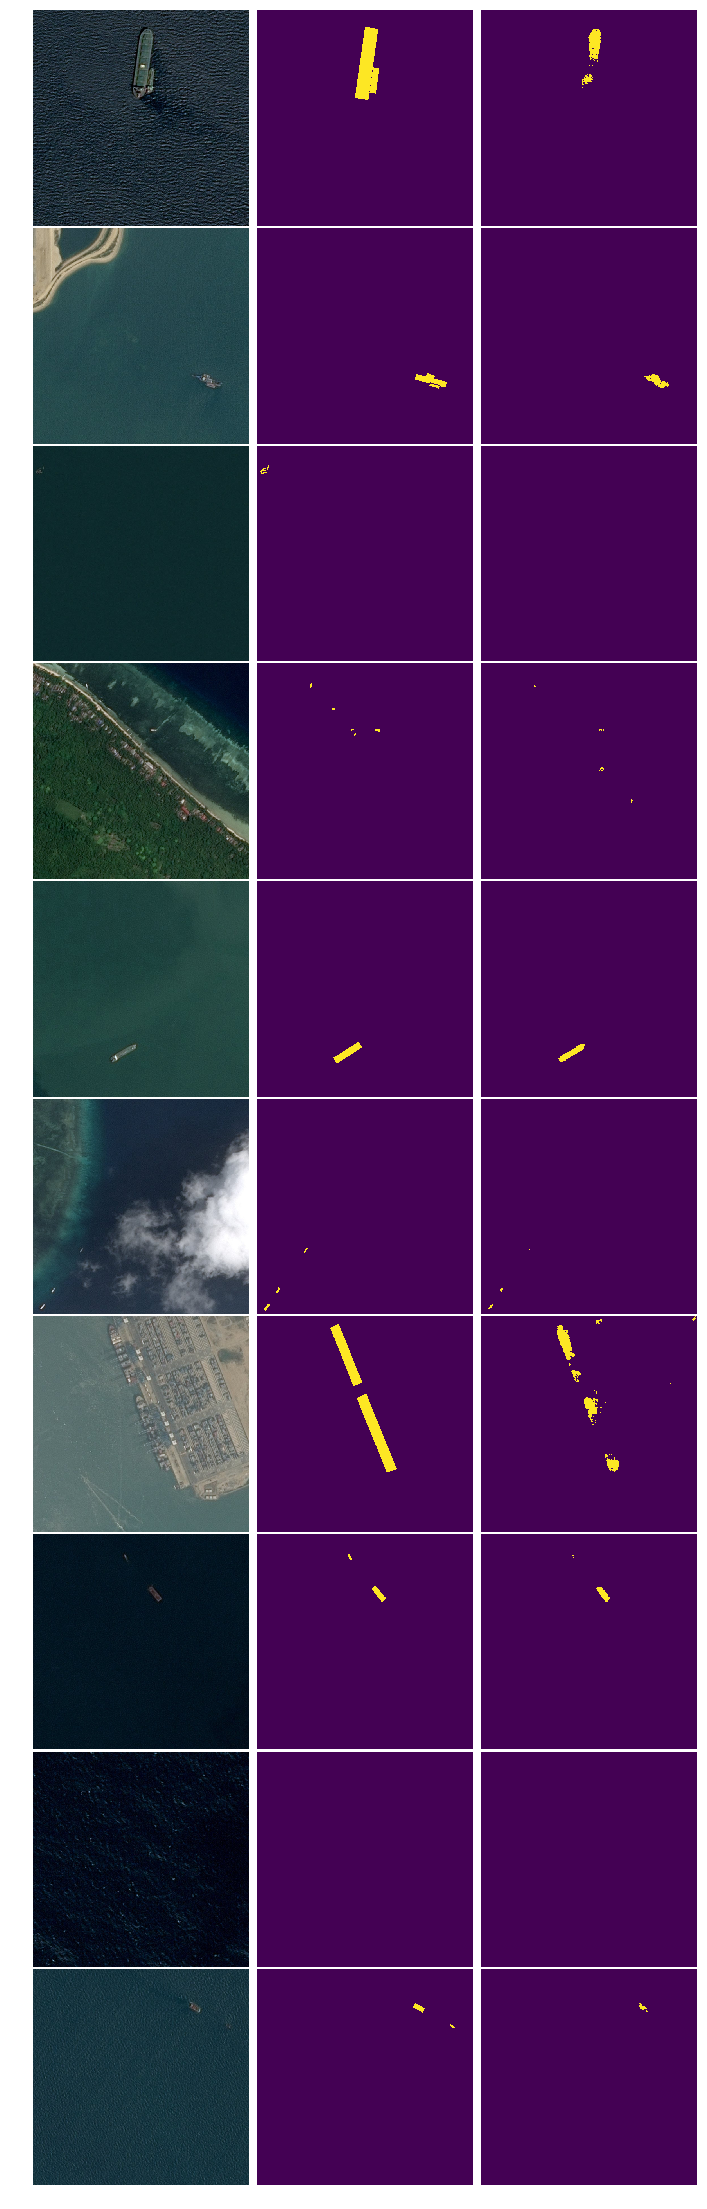

In [9]:
img_x = [0]*10
img_y = [0]*10
img_z = [0]*10
_, axes = plt.subplots(10,3,figsize=(12,40))
for i, img_name in tqdm_notebook(enumerate(label_df.index[:10])):
    print(img_name)
    img_x[i] = plt.imread(os.path.join(data_folder,img_name))
    img_x[i] = img_x[i][np.newaxis,:]
    if label_df.loc[img_name, 'HasShip'] == 0:
        img_y[i] = rle_decode_all([])
    else:
        img_y[i] = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    img_z[i] = sess.run(pixel_pred, feed_dict={x_holder:img_x[i]/255.0}) 
    axes[i][0].imshow(np.squeeze(img_x[i]))
    axes[i][0].axis("off")
    axes[i][1].imshow(img_y[i])
    axes[i][1].axis("off")
    axes[i][2].imshow(np.squeeze(img_z[i]))
    axes[i][2].axis("off")
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


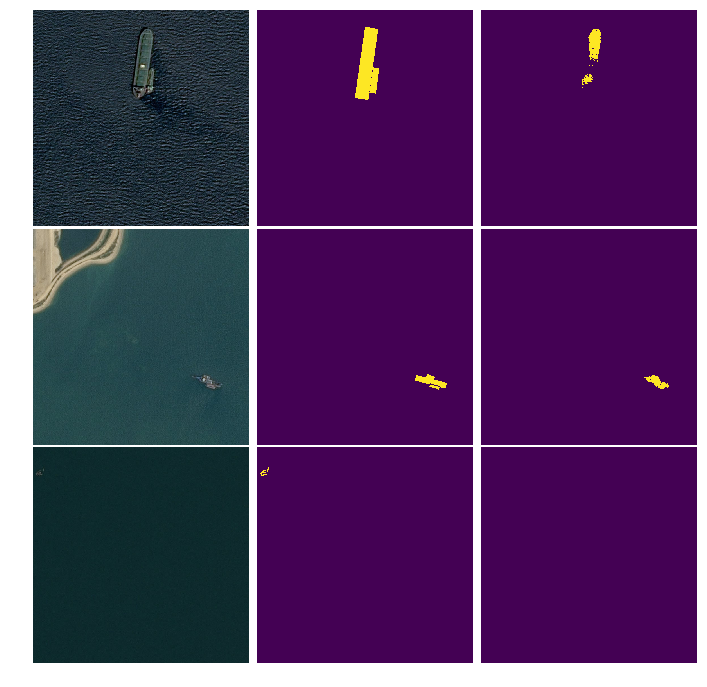

In [31]:

num = 3
img_x = [0]*num
img_y = [0]*num
img_z = [0]*num
from tqdm import tqdm_notebook
_, axes = plt.subplots(num,3,figsize=(12,4*num))
for i, img_name in tqdm_notebook(enumerate(label_df.index[:num])):
    #print(img_name)
    img_x[i] = plt.imread(os.path.join(data_folder,img_name))
    img_x[i] = img_x[i][np.newaxis,:]
    if label_df.loc[img_name, 'HasShip'] == 0:
        img_y[i] = rle_decode_all([])
    else:
        img_y[i] = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    img_z[i] = sess.run(pixel_pred, feed_dict={x_holder:img_x[i]/255.0}) 
    axes[i][0].imshow(np.squeeze(img_x[i]))
    axes[i][0].axis("off")
    axes[i][1].imshow(img_y[i])
    axes[i][1].axis("off")
    axes[i][2].imshow(np.squeeze(img_z[i]))
    axes[i][2].axis("off")
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.show()

In [32]:
jupyter nbextension enable --py --sys-prefix widgetsnbextension

SyntaxError: invalid syntax (<ipython-input-32-e3a674b8a334>, line 1)

In [42]:
with open(os.path.join("./save_model", "valid_loss"), "rb") as f:
    val_loss_his = pickle.load(f)
best_validation_loss = min(val_loss_his)

In [48]:
val_loss_his

[1.0170459406716483,
 1.0130286523274012,
 1.0123934660639082,
 1.0114179279123034,
 1.0113943415028708,
 1.0109241519655501,
 1.0109081447124482,
 1.0109657057694026,
 1.0098704610552107,
 1.0104475268295834]

In [14]:


img_name = label_df.index[3]
print(img_name)
img_x = plt.imread(os.path.join(data_folder,img_name))
if label_df.loc[img_name, 'HasShip'] == 0:
    img_y = rle_decode_all([])
else:
    print("not zero")
    img_y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
img2x, img2y = augment_img(img_x, img_y)

4ac696b08.jpg
not zero


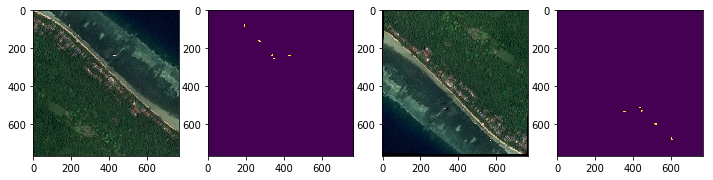

In [15]:
_, axes = plt.subplots(1,4,figsize=(12,6))
axes[0].imshow(img_x)
axes[1].imshow(img_y)
axes[2].imshow(img2x)
axes[3].imshow(img2y)
plt.show()

In [3]:
print(tf.__version__)

1.9.0


In [17]:
cv2.__version__

'3.4.2'

In [5]:
img_name = label_df.index[2]
x = cv2.imread(os.path.join(data_folder,img_name))/255.0
if label_df.loc[img_name, 'HasShip'] == 0:
    y = rle_decode_all([])
else:
    print("not zero")
    y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
print("np.sum(y)=", np.sum(y))

x = x[np.newaxis,:]
y = y.reshape((1,)+y.shape)
# image = cv2.resize(image_shape)
out = model.sess.run(model.out,feed_dict={model.x_holder:x})

not zero
np.sum(y)= 1176


In [7]:
out.shape

(1, 768, 768)

In [10]:
out = (out>0.5).astype(float)
pred = out == y
pred = pd.Series(pred.reshape((-1)))
c = pred.value_counts(normalize=True)
print(c)

True     0.921785
False    0.078215
dtype: float64


In [12]:
c = pd.Series(out.reshape((-1))).value_counts(normalize=True)
print(c)

0.0    0.923514
1.0    0.076486
dtype: float64


In [20]:
with tf.Session() as sess:
    model_dir = "./save_model"
    saver = tf.train.import_meta_graph(os.path.join(model_dir, "airbus_model.meta"))
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))

    graph = tf.get_default_graph()
    x_holder = graph.get_tensor_by_name("x_holder:0")
    y_holder = graph.get_tensor_by_name("y_holder:0")
    pixel_pred = graph.get_tensor_by_name("pixel_pred:0")
    accuracy = graph.get_tensor_by_name("accuracy:0")
    iou = graph.get_tensor_by_name("iou:0")
    
    img_name = label_df.index[2]
    x = cv2.imread(os.path.join(data_folder,img_name))/255.0
    if label_df.loc[img_name, 'HasShip'] == 0:
        y = rle_decode_all([])
    else:
        print("not zero")
        y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])

    print("np.sum(y)=", np.sum(y))

    x = x[np.newaxis,:]
    y = y.reshape((1,)+y.shape)
    
    pred, acc, iou1 = sess.run([pixel_pred, accuracy, iou], feed_dict={x_holder:x, y_holder:y})

    print(acc, iou1)

INFO:tensorflow:Restoring parameters from ./save_model/airbus_model
not zero
np.sum(y)= 1176
0.99800617 -8.5034013e-10


In [21]:
s = pd.Series(np.reshape(pred==y,(-1)))
c = s.value_counts(normalize=True)
print(c)

True     0.998006
False    0.001994
dtype: float64


In [22]:
y_true = y
y_pred = pred
intersection = np.sum(y_true * y_pred)
union = np.sum(y_true) + np.sum(y_pred) - intersection
eps = 1e-6
iou2 = -(intersection + eps) / (union + eps)
print(intersection, union, iou2)

0.0 1176.0 -8.503401353313433e-10


In [23]:
np.sum(y_pred)

0.0

In [109]:
img_name = label_df.index[2]
x = cv2.imread(os.path.join(data_folder,img_name))/255.0
if label_df.loc[img_name, 'HasShip'] == 0:
    y = rle_decode_all([])
else:
    print("not zero")
    y = rle_decode_all(label_df.loc[img_name,'EncodedPixelsList'])
    
print("np.sum(y)=", np.sum(y))

x = x[np.newaxis,:]
y = y.reshape((1,)+y.shape+(1,))
# image = cv2.resize(image_shape)
out = model.sess.run(model.out,feed_dict={model.x_holder:x})
out = tf.squeeze(out)
out = tf.cast(out > 0.5, tf.float32)
out = model.sess.run(out)
print("np.sum(out)=", np.sum(out))

pred = out == np.squeeze(y)
pred = pd.Series(pred.reshape((-1)))
c = pred.value_counts(normalize=True)
print(c)

not zero
np.sum(y)= 1176
np.sum(out)= 296660.0
False    0.502957
True     0.497043
dtype: float64


In [119]:
acc = model.sess.run(model.accuracy_op,feed_dict={model.x_holder:x, model.y_holder:y})
assert round(acc,4) == round(c[True].astype(np.float32),4), " something is wrong"